# Connect to Drive

I have another version of the current Notebook that gets the dataset and cvs files directly from the URL. But I did not have time to check that version so I used Google drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [3]:
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
import os

from tensorflow.keras.models import Model

from keras.preprocessing.image import ImageDataGenerator

# This Python 3 environment comes with many helpful analytics libraries installed
import tensorflow as tf
import pandas as pd
import numpy as np                                
import matplotlib.pyplot as plt

#from tensorflow.examples.tutorials.mnist import input_data
import keras as ks
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam     #  Aquesta línia estava malament al Github
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

#Global Variables

In [1]:
IMG_WIDTH = 332
IMG_HEIGHT=332
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)
CHANNELS = 3

database_path = '/content/drive/MyDrive/Colab Notebooks/Hackaton Schenider Electric/Database/'

#Read csv files

In [20]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Hackaton Schenider Electric/Database/train_test_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/Hackaton Schenider Electric/Database')

In [5]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hackaton Schenider Electric/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hackaton Schenider Electric/train.csv')

#Some data analysis

In [6]:
train.head()

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png


In [7]:
# How many images for training?

print("Number of train files:", len(train))
print("Number of test files:", len(test))

Number of train files: 1714
Number of test files: 635


In [8]:
# Check if unbalanced
train.label.value_counts()

0    860
2    658
1    196
Name: label, dtype: int64

The training dataset is slightly unbalanced but good enough. 

Label meaning:
0: Plantation
1: Grassland/Shrubland 
2: Smallholder Agriculture

In [32]:
# Look at some images

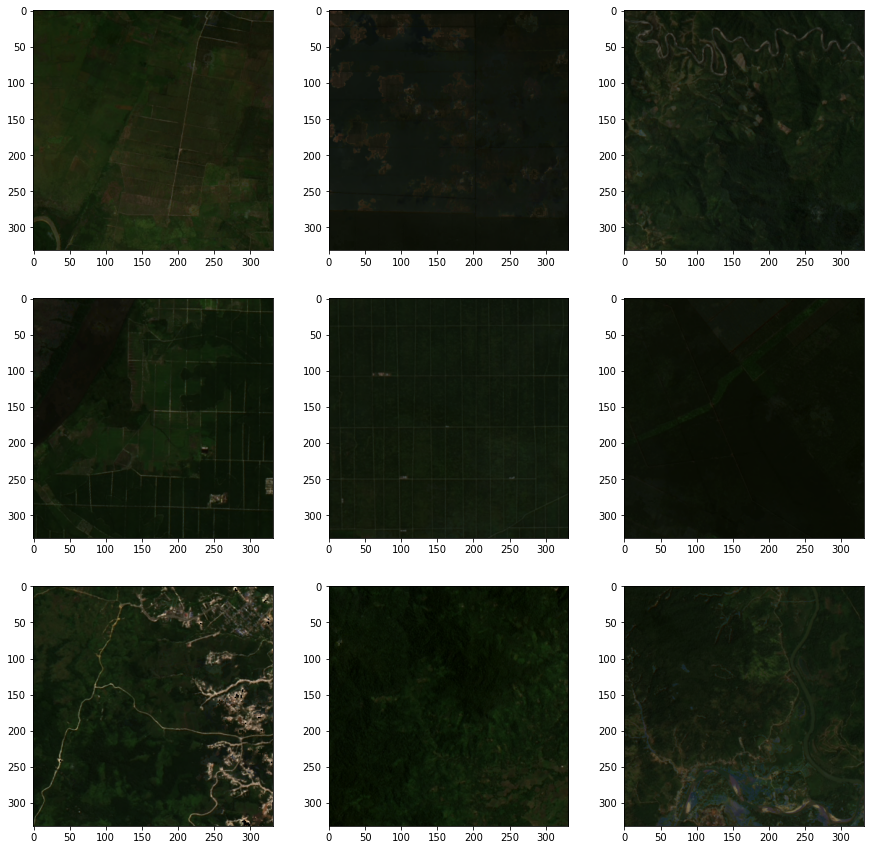

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# get some samples of the train database

db_sam = train.sample(9)

ncols = 3
nrows = 3
fig = plt.gcf()
fig.set_size_inches(ncols*5,nrows*5)
for i in range(0,9):
    sp = plt.subplot(3, 3, i+1)
    img_path =os.path.join(database_path,db_sam.iloc[i,4])
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

Seems that all images has the same size. Let's check what is their shape:

In [10]:
db_sam = train.sample(9)
for i in range(0,9):
    img_path =os.path.join(database_path,db_sam.iloc[i,4])
    img = mpimg.imread(img_path)
    print(img.shape)


(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)
(332, 332, 3)


Shape of the images is 322, 322, 3 (height, width and number of channels)

In [11]:
test.head()

,latitude,longitude,year,example_path
0,0.761681,122.755954,2006,train_test_data/test/69.png
1,-8.059785,113.053791,2007,train_test_data/test/469.png
2,-2.006610,111.746316,2002,train_test_data/test/6.png
3,0.901765,114.042495,2016,train_test_data/test/351.png
4,1.911210,100.829633,2008,train_test_data/test/1001.png


# Prepare data for the training

Let's compute the RAM needed to have the training set in it. Note that every pixel is a Float32, so 4 bytes

In [12]:
print("Data type of each pixel is:", type(img[0,0,0]))
print("the memory needed to load the training images is", len(train)*332*332*3*4)

Data type of each pixel is: <class 'numpy.float32'>
the memory needed to load the training images is 2267087232


About 2 GB. We should be able to load them all into the memory.




In [118]:
# Check the size of all images
train_img_paths = train.example_path 
a = 0
for i in range(len(train)):
#  if i%50 == 0: 
#    print(i)
  img_path =os.path.join(database_path,train_img_paths[i])
  img = mpimg.imread(img_path)
  a = a + int(img.shape == (332,332,3))
if a == len(train):
  print("All images has shape 332,332,3")


All images has shape 332,332,3


We have checked that all images has same shape.

Now we load the images to a Numpy array so we can use it to train the model with Keras.

In [14]:
train_img_paths = train.example_path
train_array = np.empty((0,332,332, 3))

for i in range(len(train)): 
  img_path =os.path.join(database_path,train_img_paths[i])
  img = mpimg.imread(img_path)
  train_array = np.append(train_array,img.reshape(1,332,332,3), axis=0)
  if i%20 == 0:
    print(i)
train_array.shape

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700


(1714, 332, 332, 3)

In [15]:
len(test)

635

In [16]:
l_test_dir = os.listdir('/content/drive/MyDrive/Colab Notebooks/Hackaton Schenider Electric/Database/train_test_data/test')
len(l_test_dir)

635

In [21]:
test_img_paths = test.example_path 
test_array = np.empty((0,332,332, 3))

for i in range(len(test)): 
  img_path =os.path.join(database_path,test_img_paths[i])
  img = mpimg.imread(img_path)
  test_array = np.append(test_array,img.reshape(1,332,332,3), axis=0)
  if i%20 == 0:
    print(i)
test_array.shape

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620


(635, 332, 332, 3)

Generate the labels of the train set

In [22]:
y_train = np.array(train['label'])
y_train

array([0, 2, 0, ..., 1, 2, 2])

In [23]:
len(y_train)

1714

We check if we should normalize data.

In [25]:
print(f"Values of x_train array varies from {train_array.min()} to {train_array.max()}")

Values of x_train array varies from 0.0 to 1.0


Values are between 0 and 1, so the data is fine for training a model.

To avoid generating a model that is adapted to the test set, we will generate validation and training datasets from the train sample set.

Since there are not many examples, we will take for validation the 25% of the total number of samples (including train and test)

In [26]:
total_samples = len(train) + len(test)
val_num_samples = int(total_samples*0.25)
train_num_samples = len(train) - val_num_samples
print("Number of samples for training:",train_num_samples)
print("Number of samples for validation:", val_num_samples)
#print(val_num_samples+train_num_samples)

Number of samples for training: 1127
Number of samples for validation: 587


We take the first 1127 samples for training and the rest for validation as we saw that samples are not ordered by type of deforestation.

In [27]:
x_val = train_array[-587:]
y_val = y_train[-587:]

In [28]:
# el train ho ha d'anar escalat!
x_train = train_array[:-587]
y_train = y_train[:-587]

In [29]:
print(x_val.shape)
print(y_val.shape)
print(x_train.shape)
print(y_train.shape)

(587, 332, 332, 3)
(587,)
(1127, 332, 332, 3)
(1127,)


# Model definition

In [52]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(332,332,3)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(500, activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(500, activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(3, activation='softmax'))


Due to that there are not many samples for training, we will use Data Augmentation technique to get more training samples and so get a regularization effect to avoid quick overfitting.

In [53]:
# set up image augmentation:  create generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3
    #shear_range = 0.2
)

In [54]:
validation_datagen = ImageDataGenerator(
    rescale=1.
    )

### Model compilation

As stated in the problem, we have to use for testing the model with best F1-score. I never calculated the F1-score in a multi-class paradigm and I found in the web that in sklearn library there is a function that calculates F1-score in such cases although there are few variants. (metrics.classification_report()). I am unsure how to build so it can be accepted in the metrics argument in the compilation of the model and I finally decided to keep going using the accuracy as the metric.

Anyway, below are my first steps trying to get the F1-score

In [66]:
# Trying to get get F1_score with sklearn

from sklearn import metrics

# Constants
C="0"
F="1"
H="2"

# True values
y_true = [C,C,C,C,C,C, F,F,F,F,F,F,F,F,F,F, H,H,H,H,H,H,H,H,H]
# Predicted values
y_pred = [C,C,C,C,H,F, C,C,C,C,C,C,H,H,F,F, C,C,C,H,H,H,H,H,H]

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))
a = metrics.classification_report(y_true, y_pred, digits=3)

metrics.f1_score(y_true, y_pred, labels=["0","1","2"], average='macro')



[[4 1 1]
 [6 2 2]
 [3 0 6]]
              precision    recall  f1-score   support

           0      0.308     0.667     0.421         6
           1      0.667     0.200     0.308        10
           2      0.667     0.667     0.667         9

    accuracy                          0.480        25
   macro avg      0.547     0.511     0.465        25
weighted avg      0.581     0.480     0.464        25



0.46513720197930725

In [55]:
# Create a function that to try in the compilation of the model. It finally was not tried and I used the usual "accuracy" metric 

def get_f1(y_true, y_pred): 
    f1_val=metrics.f1_score(y_true, y_pred, labels=["0","1","2"], average='macro')
    return f1_val

In [40]:
#model.compile(loss='sparse_categorical_crossentropy', metrics=[get_f1],optimizer="Adam")

## Compile model with accuracy metric

In [56]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'],optimizer="Adam")

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 332, 332, 64)      1792      
                                                                 
 batch_normalization_12 (Bat  (None, 332, 332, 64)     256       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 332, 332, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 332, 332, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 166, 166, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_13 (Bat  (None, 166, 166, 64)    

## Add callbacks for early stopping and to do a checkpoint of the best model only.

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
callback_val_accuracy = EarlyStopping(monitor='val_accuracy', patience = 30)
callback_val_loss = EarlyStopping(monitor="val_loss", patience=30)
# Fem un callback per gravar un model (checkpoint), i li donem el path del Colab '/content/modelchk'
modelbackup = ModelCheckpoint('./modelchk', monitor='val_loss', save_best_only=True)

Definition of the flow for the image generators

In [59]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=30)
validation_generator = validation_datagen.flow(x_val,y_val, batch_size=20)

##Fitting the model

In [60]:
# Calculating steps_per_epoch and validation_steps
print(len(x_train)/30)   
print(len(x_val)/20)  

37.56666666666667
29.35


We are going to use steps_per_epoch = 38 and validation_steps=30 

In [61]:
epochs = 200

# train with image augmentation
history=model.fit(train_generator,callbacks=[callback_val_loss, callback_val_accuracy, modelbackup],
                    steps_per_epoch = 38, epochs=200,   #  steps_per_epoch = len(x_train)/batch size en training = 
                    validation_steps = 30, validation_data=validation_generator)  

Epoch 1/200
38/38 [==============================] - ETA: 0s - loss: 1.8111 - accuracy: 0.3878

38/38 [==============================] - 32s 789ms/step - loss: 1.8111 - accuracy: 0.3878 - val_loss: 1.0220 - val_accuracy: 0.4736
Epoch 2/200
38/38 [==============================] - 24s 641ms/step - loss: 1.4771 - accuracy: 0.4499 - val_loss: 1.2943 - val_accuracy: 0.4736
Epoch 3/200
38/38 [==============================] - 24s 633ms/step - loss: 1.3272 - accuracy: 0.4925 - val_loss: 1.0399 - val_accuracy: 0.4736
Epoch 4/200
38/38 [==============================] - 24s 633ms/step - loss: 1.2437 - accuracy: 0.4907 - val_loss: 1.2084 - val_accuracy: 0.3935
Epoch 5/200
38/38 [==============================] - 24s 633ms/step - loss: 1.1914 - accuracy: 0.5235 - val_loss: 1.0411 - val_accuracy: 0.4736
Epoch 6/200
38/38 [==============================] - 24s 634ms/step - loss: 1.1816 - accuracy: 0.5315 - val_loss: 1.2152 - val_accuracy: 0.4651
Epoch 7/200
38/38 [==============================] - 24s 631ms/step - loss: 1.0730 - accuracy: 0.5173 - val_loss: 1.1912 - val_accuracy: 0.4736
Epoc

38/38 [==============================] - 29s 773ms/step - loss: 0.9590 - accuracy: 0.5643 - val_loss: 1.0073 - val_accuracy: 0.4923
Epoch 14/200
38/38 [==============================] - 24s 631ms/step - loss: 0.9239 - accuracy: 0.5945 - val_loss: 1.2789 - val_accuracy: 0.4736
Epoch 15/200
38/38 [==============================] - 24s 636ms/step - loss: 0.8832 - accuracy: 0.5980 - val_loss: 1.2897 - val_accuracy: 0.4770
Epoch 16/200
38/38 [==============================] - 24s 632ms/step - loss: 0.8878 - accuracy: 0.6105 - val_loss: 1.1182 - val_accuracy: 0.5622
Epoch 17/200
38/38 [==============================] - 24s 633ms/step - loss: 0.8432 - accuracy: 0.6300 - val_loss: 1.2966 - val_accuracy: 0.4736
Epoch 18/200
38/38 [==============================] - ETA: 0s - loss: 0.8552 - accuracy: 0.6247

38/38 [==============================] - 30s 787ms/step - loss: 0.8552 - accuracy: 0.6247 - val_loss: 0.9703 - val_accuracy: 0.4889
Epoch 19/200
38/38 [==============================] - 24s 631ms/step - loss: 0.8130 - accuracy: 0.6637 - val_loss: 4.0278 - val_accuracy: 0.4736
Epoch 20/200
38/38 [==============================] - 24s 638ms/step - loss: 0.7820 - accuracy: 0.6655 - val_loss: 2.8906 - val_accuracy: 0.4736
Epoch 21/200
38/38 [==============================] - 24s 637ms/step - loss: 0.7954 - accuracy: 0.6646 - val_loss: 1.2476 - val_accuracy: 0.5026
Epoch 22/200
38/38 [==============================] - 24s 632ms/step - loss: 0.7778 - accuracy: 0.6726 - val_loss: 2.1277 - val_accuracy: 0.4889
Epoch 23/200
38/38 [==============================] - 24s 631ms/step - loss: 0.7376 - accuracy: 0.6886 - val_loss: 0.9954 - val_accuracy: 0.5622
Epoch 24/200
38/38 [==============================] - 24s 640ms/step - loss: 0.7607 - accuracy: 0.6939 - val_loss: 2.2424 - val_accuracy: 0.485

38/38 [==============================] - 30s 792ms/step - loss: 0.6456 - accuracy: 0.7462 - val_loss: 0.8970 - val_accuracy: 0.6797
Epoch 35/200
38/38 [==============================] - 24s 631ms/step - loss: 0.6709 - accuracy: 0.7285 - val_loss: 1.6429 - val_accuracy: 0.4838
Epoch 36/200
38/38 [==============================] - 24s 637ms/step - loss: 0.6577 - accuracy: 0.7329 - val_loss: 1.0892 - val_accuracy: 0.5860
Epoch 37/200
38/38 [==============================] - 24s 634ms/step - loss: 0.6362 - accuracy: 0.7453 - val_loss: 1.7014 - val_accuracy: 0.5179
Epoch 38/200
38/38 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.7347

38/38 [==============================] - 30s 782ms/step - loss: 0.6246 - accuracy: 0.7347 - val_loss: 0.8865 - val_accuracy: 0.6763
Epoch 39/200
38/38 [==============================] - 24s 635ms/step - loss: 0.6476 - accuracy: 0.7471 - val_loss: 1.0125 - val_accuracy: 0.5605
Epoch 40/200
38/38 [==============================] - 24s 640ms/step - loss: 0.6275 - accuracy: 0.7551 - val_loss: 1.5138 - val_accuracy: 0.5622
Epoch 41/200
38/38 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.7303

38/38 [==============================] - 30s 791ms/step - loss: 0.6604 - accuracy: 0.7303 - val_loss: 0.8395 - val_accuracy: 0.6797
Epoch 42/200
38/38 [==============================] - 24s 633ms/step - loss: 0.6347 - accuracy: 0.7356 - val_loss: 1.0155 - val_accuracy: 0.6440
Epoch 43/200
38/38 [==============================] - 24s 633ms/step - loss: 0.6354 - accuracy: 0.7560 - val_loss: 1.1009 - val_accuracy: 0.6150
Epoch 44/200
38/38 [==============================] - 24s 632ms/step - loss: 0.6443 - accuracy: 0.7294 - val_loss: 0.9994 - val_accuracy: 0.6218
Epoch 45/200
38/38 [==============================] - 24s 635ms/step - loss: 0.6210 - accuracy: 0.7542 - val_loss: 1.6540 - val_accuracy: 0.5758
Epoch 46/200
38/38 [==============================] - 24s 631ms/step - loss: 0.6297 - accuracy: 0.7542 - val_loss: 1.1831 - val_accuracy: 0.5928
Epoch 47/200
38/38 [==============================] - 24s 635ms/step - loss: 0.6220 - accuracy: 0.7516 - val_loss: 1.0838 - val_accuracy: 0.557

38/38 [==============================] - 30s 786ms/step - loss: 0.6035 - accuracy: 0.7604 - val_loss: 0.7831 - val_accuracy: 0.7274
Epoch 49/200
38/38 [==============================] - 25s 644ms/step - loss: 0.6531 - accuracy: 0.7267 - val_loss: 0.8018 - val_accuracy: 0.7121
Epoch 50/200
38/38 [==============================] - 24s 632ms/step - loss: 0.6288 - accuracy: 0.7436 - val_loss: 0.8872 - val_accuracy: 0.6388
Epoch 51/200
38/38 [==============================] - 24s 632ms/step - loss: 0.6146 - accuracy: 0.7604 - val_loss: 1.1077 - val_accuracy: 0.6354
Epoch 52/200
38/38 [==============================] - 24s 634ms/step - loss: 0.5848 - accuracy: 0.7649 - val_loss: 0.8598 - val_accuracy: 0.6899
Epoch 53/200
38/38 [==============================] - 25s 647ms/step - loss: 0.6361 - accuracy: 0.7427 - val_loss: 1.7240 - val_accuracy: 0.5383
Epoch 54/200
38/38 [==============================] - 24s 631ms/step - loss: 0.6101 - accuracy: 0.7657 - val_loss: 0.8457 - val_accuracy: 0.630

38/38 [==============================] - 30s 784ms/step - loss: 0.6074 - accuracy: 0.7595 - val_loss: 0.7418 - val_accuracy: 0.7428
Epoch 56/200
38/38 [==============================] - 24s 634ms/step - loss: 0.6275 - accuracy: 0.7640 - val_loss: 0.9533 - val_accuracy: 0.6763
Epoch 57/200
38/38 [==============================] - 24s 633ms/step - loss: 0.6018 - accuracy: 0.7445 - val_loss: 1.0274 - val_accuracy: 0.6150
Epoch 58/200
38/38 [==============================] - 24s 632ms/step - loss: 0.5791 - accuracy: 0.7693 - val_loss: 2.2464 - val_accuracy: 0.5094
Epoch 59/200
38/38 [==============================] - 24s 634ms/step - loss: 0.5935 - accuracy: 0.7649 - val_loss: 1.0361 - val_accuracy: 0.6133
Epoch 60/200
38/38 [==============================] - 24s 636ms/step - loss: 0.6243 - accuracy: 0.7427 - val_loss: 0.8854 - val_accuracy: 0.7189
Epoch 61/200
38/38 [==============================] - 24s 633ms/step - loss: 0.5873 - accuracy: 0.7657 - val_loss: 0.9305 - val_accuracy: 0.637

38/38 [==============================] - 30s 781ms/step - loss: 0.5382 - accuracy: 0.7844 - val_loss: 0.6611 - val_accuracy: 0.7768
Epoch 76/200
38/38 [==============================] - 24s 641ms/step - loss: 0.5282 - accuracy: 0.7897 - val_loss: 0.6797 - val_accuracy: 0.7513
Epoch 77/200
38/38 [==============================] - 24s 634ms/step - loss: 0.5502 - accuracy: 0.7906 - val_loss: 0.7512 - val_accuracy: 0.7274
Epoch 78/200
38/38 [==============================] - 24s 634ms/step - loss: 0.5204 - accuracy: 0.7888 - val_loss: 1.0037 - val_accuracy: 0.6865
Epoch 79/200
38/38 [==============================] - 24s 632ms/step - loss: 0.5378 - accuracy: 0.7870 - val_loss: 0.7784 - val_accuracy: 0.7172
Epoch 80/200
38/38 [==============================] - 24s 636ms/step - loss: 0.5352 - accuracy: 0.7968 - val_loss: 0.9468 - val_accuracy: 0.6763
Epoch 81/200
38/38 [==============================] - 25s 643ms/step - loss: 0.5247 - accuracy: 0.7915 - val_loss: 0.6683 - val_accuracy: 0.766

38/38 [==============================] - 30s 789ms/step - loss: 0.5513 - accuracy: 0.7897 - val_loss: 0.6509 - val_accuracy: 0.7717
Epoch 87/200
38/38 [==============================] - 24s 635ms/step - loss: 0.5272 - accuracy: 0.7950 - val_loss: 1.6968 - val_accuracy: 0.5162
Epoch 88/200
38/38 [==============================] - 24s 634ms/step - loss: 0.5224 - accuracy: 0.7959 - val_loss: 1.6654 - val_accuracy: 0.5281
Epoch 89/200
38/38 [==============================] - 24s 638ms/step - loss: 0.5298 - accuracy: 0.7915 - val_loss: 0.7949 - val_accuracy: 0.7513
Epoch 90/200
38/38 [==============================] - 24s 632ms/step - loss: 0.5573 - accuracy: 0.7844 - val_loss: 1.4901 - val_accuracy: 0.5366
Epoch 91/200
38/38 [==============================] - 24s 637ms/step - loss: 0.5228 - accuracy: 0.8039 - val_loss: 1.2396 - val_accuracy: 0.6695
Epoch 92/200
38/38 [==============================] - 24s 634ms/step - loss: 0.5233 - accuracy: 0.7924 - val_loss: 0.7609 - val_accuracy: 0.734

38/38 [==============================] - 30s 789ms/step - loss: 0.4943 - accuracy: 0.8057 - val_loss: 0.6486 - val_accuracy: 0.7649
Epoch 97/200
38/38 [==============================] - 24s 636ms/step - loss: 0.5136 - accuracy: 0.7897 - val_loss: 0.9642 - val_accuracy: 0.6814
Epoch 98/200
38/38 [==============================] - 24s 632ms/step - loss: 0.5129 - accuracy: 0.8012 - val_loss: 0.6699 - val_accuracy: 0.7615
Epoch 99/200
38/38 [==============================] - 24s 636ms/step - loss: 0.5486 - accuracy: 0.7817 - val_loss: 0.7989 - val_accuracy: 0.7206
Epoch 100/200
38/38 [==============================] - 24s 632ms/step - loss: 0.5036 - accuracy: 0.8092 - val_loss: 0.6500 - val_accuracy: 0.7734
Epoch 101/200
38/38 [==============================] - 24s 633ms/step - loss: 0.5087 - accuracy: 0.8154 - val_loss: 0.6726 - val_accuracy: 0.7632
Epoch 102/200
38/38 [==============================] - 24s 638ms/step - loss: 0.5304 - accuracy: 0.7870 - val_loss: 0.7063 - val_accuracy: 0.

38/38 [==============================] - 30s 787ms/step - loss: 0.4927 - accuracy: 0.8083 - val_loss: 0.5764 - val_accuracy: 0.7990
Epoch 105/200
38/38 [==============================] - 24s 635ms/step - loss: 0.5090 - accuracy: 0.7995 - val_loss: 0.6633 - val_accuracy: 0.7598
Epoch 106/200
38/38 [==============================] - 24s 633ms/step - loss: 0.4881 - accuracy: 0.8146 - val_loss: 0.6728 - val_accuracy: 0.7768
Epoch 107/200
38/38 [==============================] - 24s 632ms/step - loss: 0.4983 - accuracy: 0.8066 - val_loss: 0.6378 - val_accuracy: 0.7717
Epoch 108/200
38/38 [==============================] - 24s 633ms/step - loss: 0.4753 - accuracy: 0.8181 - val_loss: 0.8038 - val_accuracy: 0.6797
Epoch 109/200
38/38 [==============================] - 24s 630ms/step - loss: 0.5321 - accuracy: 0.7950 - val_loss: 0.9540 - val_accuracy: 0.6814
Epoch 110/200
38/38 [==============================] - 24s 631ms/step - loss: 0.4980 - accuracy: 0.8066 - val_loss: 0.6591 - val_accuracy:

Save the last model and load the best model for the testing

In [67]:
model.save('./modelchk/'+'model_with_data_augm.h5')

In [68]:
model.load_weights('./modelchk')

In [69]:
model.save('./modelchk/'+'model_with_data_augm_BEST.h5')

Get predictions

In [72]:
Y_test_predict = model.predict(test_array)
Y_test_predict

20/20 [==============================] - 1s 31ms/step


array([[1.9179757e-01, 6.1447090e-03, 8.0205774e-01],
       [2.2761006e-02, 5.6137472e-02, 9.2110151e-01],
       [6.1943763e-01, 8.0710119e-03, 3.7249130e-01],
       ...,
       [1.6488633e-01, 2.5225464e-01, 5.8285898e-01],
       [9.9996758e-01, 1.1161902e-06, 3.1377898e-05],
       [9.5379579e-01, 3.2834526e-02, 1.3369684e-02]], dtype=float32)

In [110]:
index_max = np.argmax(Y_test_predict,axis=1,)


In [81]:
test_img_paths[0].split('/')

['train_test_data', 'test', '69.png']

In [89]:
path.split('/')[2].split('.')[0]
pred_labels = []
pred_labels.append("a")

Create the json file with predicted labels

In [99]:
# Firstly we do a list with the labels. 
pred_labels = []
for path in test_img_paths:
  pred_labels.append(path.split('/')[2].split('.')[0])

In [111]:
# Transform the type of the lables from Int64 to Ins so that the json.dump() function doesn't give error

print(len(index_max), sum(index_max), type(index_max[0]))
predictions = []
for i in index_max:
  predictions.append(int(i))
print(len(predictions), sum(predictions), type(predictions[0]))

635 555 <class 'numpy.int64'>
635 555 <class 'int'>


In [112]:
pred_dictionary = dict(zip(pred_labels, predictions))

In [113]:
final_pred_dictionary = {"target":pred_dictionary}

In [117]:
import json
    
with open("./predictions.json", "w") as outfile:
    json.dump(final_pred_dictionary, outfile,indent=2)


# The end! Fingers crossed!